In [267]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [268]:
import xarray as xr
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from xmitgcm import utils

from xhistogram.xarray import histogram
from dask.diagnostics import ProgressBar

In [269]:
import sys
sys.path.append("scripts")
from filesystem import *

### Load full 3D snapshots

In [270]:
ds, grid = load_RT_canyon_hydrostatic()
release_time = np.datetime64(ds.release_time)
dye_loc = ds.dye_release_loc
    
# Small chunks to make xhistogram happy
ds = ds.chunk({'Z':10})

### Determine "canyon-aligned" coordinate frame

##### Load trajectory of tracer centroid

In [272]:
out = xr.open_dataset("data/tracer_stats.nc")
out = out.assign_coords({'hours_since_release': ((out['time'] - release_time)/(1.e9)).astype('float64')/3600.})
short_ds = out.sel(time=slice(release_time, release_time + np.timedelta64(48,'h')))

##### Project spherical coordinates to rectilinear coordinates on local tangent plane

In [273]:
R = 6.371e6
circ = 2.*np.pi*R

# Tracer centroid trajectory
short_ds['X_bar'] = (short_ds['XC_bar'] - dye_loc[0]) * circ/360. * np.cos(np.deg2rad(dye_loc[1]))
short_ds['Y_bar'] = (short_ds['YC_bar'] - dye_loc[1]) * circ/360.

# 3D model grid
ds = ds.assign_coords({
    'X': (ds['XC'] - dye_loc[0]) * circ/360. * np.cos(np.deg2rad(dye_loc[1])),
    'Y': (ds['YC'] - dye_loc[1]) * circ/360.
})

##### Compute rotation angle for transforming to rectilinear coordinate frame aligned with local flow direction (from tracer)

In [274]:
# Compute angle of flow-aligned coordinate relative to west-east/south-north directions
a,b = np.polyfit(short_ds['X_bar'], short_ds['Y_bar'], 1)
θ = np.arctan(a)

##### Generate target grid (aligned with flow)

In [275]:
dxhat = 50.
dyhat = 50.

Lxhat = 24.e3
Lyhat = 6.e3

Nxhat = np.int64(Lxhat//dxhat)
Nyhat = np.int64(Lyhat//dyhat)

xhat_1d = np.arange(-Lxhat/2 + dxhat/2., Lxhat/2. + dxhat/2., dxhat)[:, np.newaxis]
yhat_1d = np.arange(-Lyhat/2 + dyhat/2., Lyhat/2. + dyhat/2., dyhat)[np.newaxis, :]

##### Mapping from target grid to simulation grid

In [276]:
x = np.cos(θ)*xhat_1d - np.sin(θ)*yhat_1d
y = np.cos(θ)*yhat_1d + np.sin(θ)*xhat_1d

##### Interpolate simulation output to target grid

In [277]:
from scipy.interpolate import griddata

gridcells = xr.Dataset({
    'X': xr.DataArray(x.flatten(), dims='cell'),
    'Y': xr.DataArray(y.flatten(), dims='cell'),
})

nds_flat = ds.swap_dims({'YC':'Y', 'XC':'X'}).interp(gridcells, method='linear')
nds_flat = nds_flat.assign_coords({"Xhat": xhat_1d.flatten(), "Yhat": yhat_1d.flatten()})
nds = nds_flat.stack(cell=("Xhat", "Yhat")).unstack("cell").transpose('Yhat', 'Xhat', ...)

##### Integrate tracer across channel

(-1800.0, -1600.0)

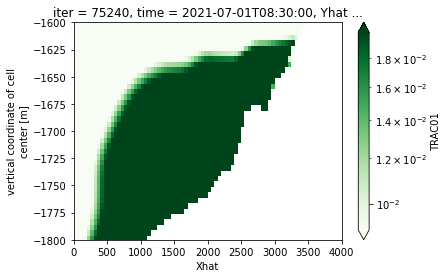

In [286]:
nds['TRAC01'].sel(Yhat=0., method="nearest").isel(time=104).plot(x="Xhat", cmap="Greens", norm=matplotlib.colors.LogNorm(vmax=10.**(-2.), vmin=10.**(-1.7)))
plt.xlim(0, 4000)
plt.ylim(-1800, -1600)

In [278]:
TRAC01_int = (nds['TRAC01']*dyhat).sum("Yhat").isel(time=90)

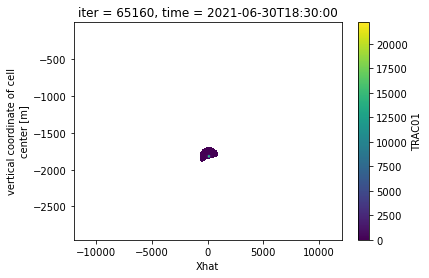

In [279]:
TRAC01_int.where(TRAC01_int!=0.).plot(x="Xhat")

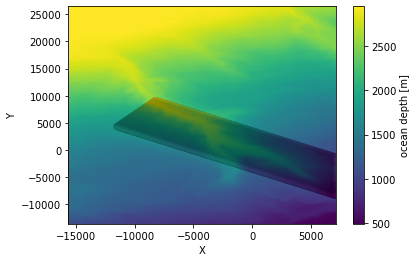

In [82]:
ds['Depth'].plot(x='X', y='Y')
plt.scatter(nds['X'].values.flatten(), nds['Y'].values.flatten(), c=nds['Depth'].values.flatten(), edgecolors="k", linewidths=0.1, alpha=0.5)

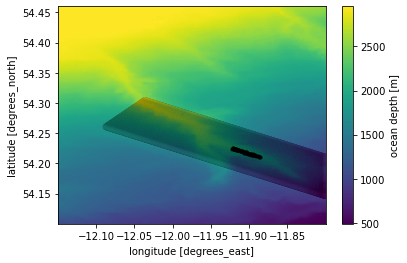

In [42]:
ds['Depth'].plot(x='XC', y='YC')
plt.scatter(tt['XC'].values.flatten(), tt['YC'].values.flatten(), c=tt.values.flatten(), edgecolors="k", linewidths=0.1, alpha=0.5)
plt.plot(short_ds['XC_bar'], short_ds['YC_bar'], "k.")

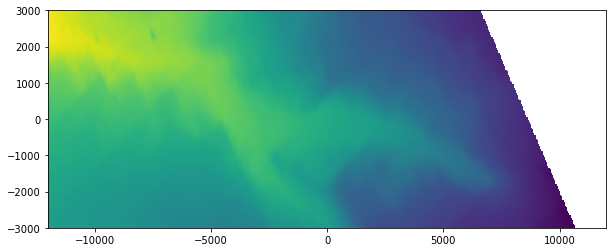

In [43]:
plt.figure(figsize=(10,4))
plt.pcolor(x_1d.flatten(), y_1d.flatten(), tt.values.reshape((x_1d.size, y_1d.size)).transpose())

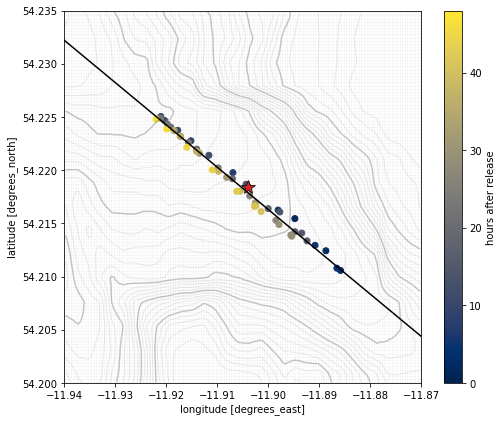

In [ ]:
plt.figure(figsize=(8, 6.85))
plt.scatter(short_ds['XC_bar'], short_ds['YC_bar'], c=short_ds['hours_since_release'], vmin=0, vmax=48, cmap="cividis")
plt.colorbar(label="hours after release")
plt.plot(short_ds['XC_bar'][0], short_ds['YC_bar'][0], "C3*", markersize=15, mec="k", markeredgewidth=0.75)

xlims = [-11.94, -11.87]
ylims = [54.20, 54.235]
ds['Depth'].sel(XC=slice(xlims[0], xlims[1]), YC=slice(ylims[0], ylims[1])).plot.contour(levels=np.arange(2000, 1400, -20), colors='gray', linewidths=1., alpha=0.15)
ds['Depth'].sel(XC=slice(xlims[0], xlims[1]), YC=slice(ylims[0], ylims[1])).plot.contour(levels=np.arange(2000, 1400, -100), colors='gray', linewidths=1.5, alpha=0.35)

a,b = np.polyfit(short_ds['XC_bar'], short_ds['YC_bar'], 1)
plt.plot(ds['XC'], a * ds['XC'] + b, "k-")
plt.xlim(xlims)
plt.ylim(ylims)

for x in ds['XC']:
    plt.axvline(x, color="k", linewidth=0.5, alpha=0.05)
    
for y in ds['YC']:
    plt.axhline(y, color="k", linewidth=0.5, alpha=0.05)

In [9]:
ids = small_ds.interp(XC=x, YC=y)

with ProgressBar():
    ids.compute()
    
ids.to_netcdf("data/upcanyon_section.nc")
ids.close()

[########################################] | 100% Completed | 23min  7.5s
